# I. Overview of Dataset

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from pycaret.classification import *
from scipy.stats import norm
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error


In [2]:
# Load data
df = pd.read_excel('diamond.csv'')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9142 entries, 0 to 9141
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID           9142 non-null   int64  
 1   CaratWeight  9142 non-null   float64
 2   Cut          9142 non-null   object 
 3   Color        9142 non-null   object 
 4   Clarity      9142 non-null   object 
 5   Polish       9142 non-null   object 
 6   Symmetry     9142 non-null   object 
 7   Report       9142 non-null   object 
 8   Price        9142 non-null   int64  
dtypes: float64(1), int64(2), object(6)
memory usage: 642.9+ KB


In [3]:
df.describe()

,ID,CaratWeight,Price
count,9142.000000,9142.000000,9142.000000
mean,4571.500000,1.336139,11799.315139
std,2639.212414,0.476585,10083.431567
min,1.000000,0.750000,2184.000000
25%,2286.250000,1.010000,5195.000000
50%,4571.500000,1.130000,7868.000000
75%,6856.750000,1.590000,15097.500000
max,9142.000000,2.910000,101561.000000


# II. Data Cleaning

In [4]:
missing_values = df.isnull().sum()

duplicate_records = df.duplicated().sum()

print("Missing Values:", missing_values)

print()

print("Duplicates:", duplicate_records) 

Missing Values: ID             0
CaratWeight    0
Cut            0
Color          0
Clarity        0
Polish         0
Symmetry       0
Report         0
Price          0
dtype: int64

Duplicates: 0


# III. Exploratory data analysis (EDA)

## 1. Outlier Analysis

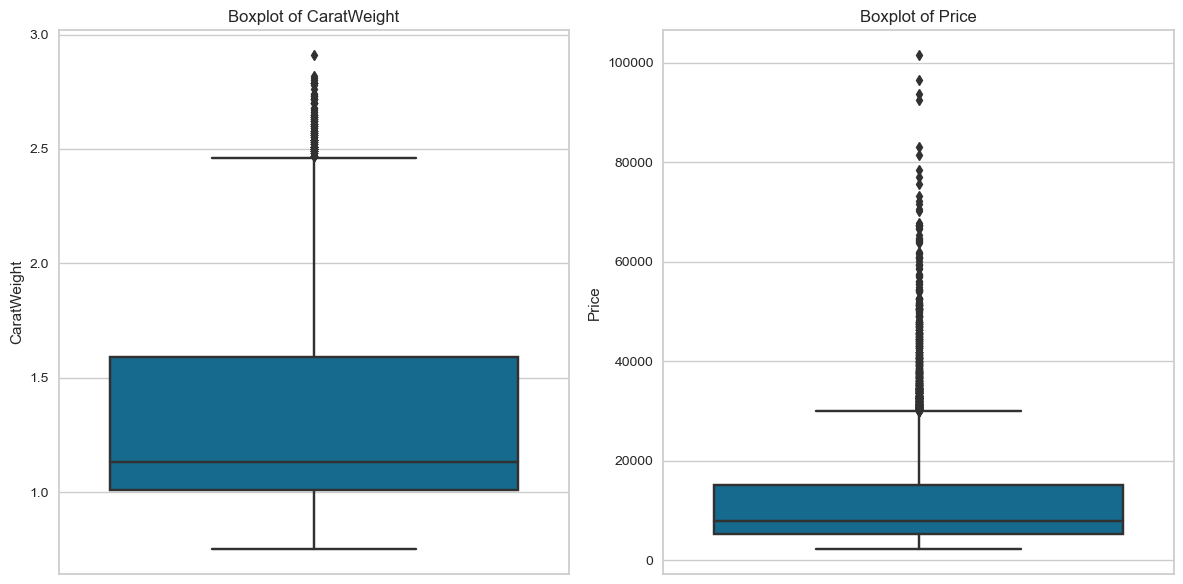

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Summary statistics for numerical columns
summary_statistics = df[['CaratWeight', 'Price']].describe()

# Boxplot to visualize outliers
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(y=df['CaratWeight'])
plt.title('Boxplot of CaratWeight')

plt.subplot(1, 2, 2)
sns.boxplot(y=df['Price'])
plt.title('Boxplot of Price')

plt.tight_layout()
plt.show()

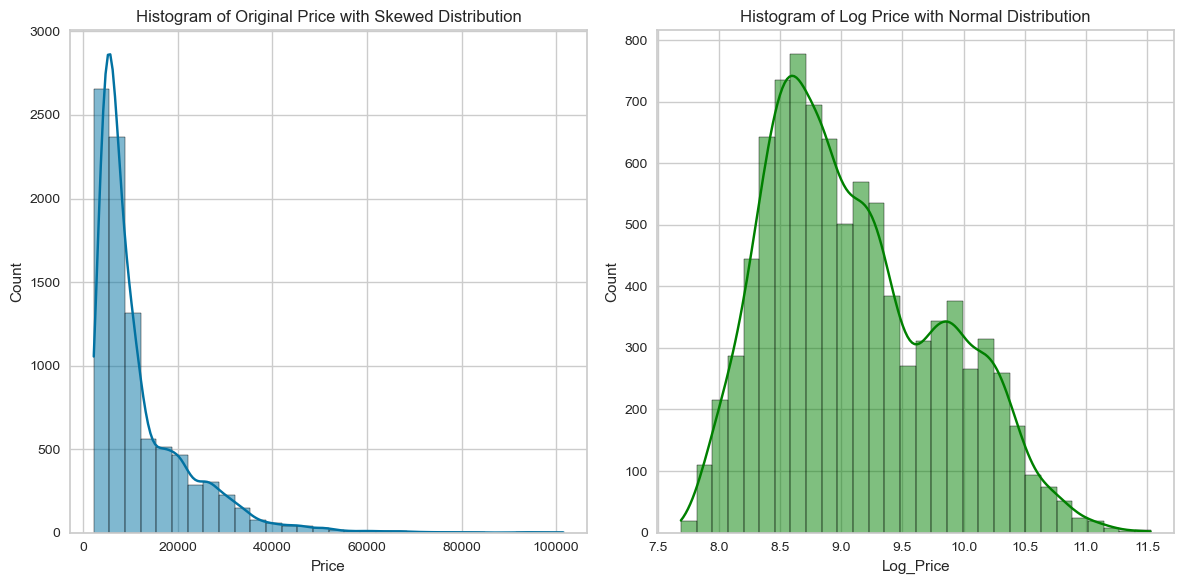

count    9142.000000
mean        9.104233
std         0.705954
min         7.688913
25%         8.555452
50%         8.970559
75%         9.622284
max        11.528415
Name: Log_Price, dtype: float64

In [6]:
import numpy as np

# Apply log transformation to the Price column
df['Log_Price'] = np.log(df['Price'])

# Plot histograms for original and transformed Price data
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(df['Price'], kde=True, bins=30)
plt.title('Histogram of Original Price with Skewed Distribution')

plt.subplot(1, 2, 2)
sns.histplot(df['Log_Price'], kde=True, color='green', bins=30)
plt.title('Histogram of Log Price with Normal Distribution')

plt.tight_layout()
plt.show()

# Summary statistics for the transformed data
log_price_stats = df['Log_Price'].describe()
log_price_stats

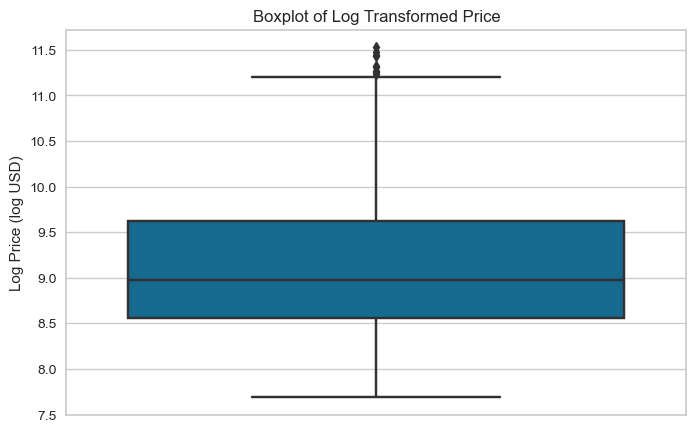

{'Lower Bound': 6.955203210520526,
 'Upper Bound': 11.222533058554664,
 'Outliers Count': 9,
 'Total Count': 9142,
 'Outlier Proportion (%)': 0.09844672938087945}

In [7]:
# Boxplot to visualize outliers in the log-transformed Price
plt.figure(figsize=(8, 5))
sns.boxplot(y=df['Log_Price'])
plt.title('Boxplot of Log Transformed Price')
plt.ylabel('Log Price (log USD)')
plt.show()

# Compute and display additional outlier information based on IQR
Q1 = df['Log_Price'].quantile(0.25)
Q3 = df['Log_Price'].quantile(0.75)
IQR = Q3 - Q1

# Define outliers as those outside of Q1 - 1.5*IQR and Q3 + 1.5*IQR
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Count outliers
outliers = df[(df['Log_Price'] < lower_bound) | (df['Log_Price'] > upper_bound)]
outlier_proportion = len(outliers) / len(df) * 100

outlier_summary = {
    "Lower Bound": lower_bound,
    "Upper Bound": upper_bound,
    "Outliers Count": len(outliers),
    "Total Count": len(df),
    "Outlier Proportion (%)": outlier_proportion
}

outlier_summary

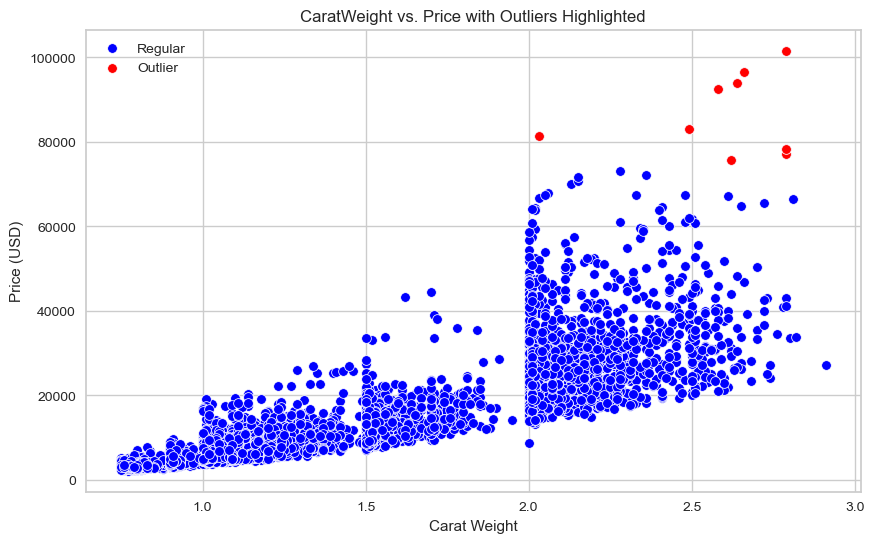

,ID,CaratWeight,Cut,Color,Clarity,Polish,Symmetry,Report,Price,Log_Price
188,189,2.66,Ideal,D,FL,EX,EX,GIA,96493,11.477226
810,811,2.62,Ideal,D,VVS1,EX,EX,GIA,75630,11.233608
1881,1882,2.64,Very Good,D,IF,VG,EX,GIA,93813,11.449059
3192,3193,2.79,Ideal,D,IF,EX,EX,GIA,101561,11.528415
4257,4258,2.03,Signature-Ideal,D,FL,EX,EX,GIA,81399,11.307118
4401,4402,2.49,Very Good,D,IF,VG,VG,GIA,83145,11.328341
4670,4671,2.79,Ideal,D,VVS2,EX,EX,GIA,77033,11.251989
7963,7964,2.79,Very Good,D,VVS2,EX,G,GIA,78423,11.269873
8719,8720,2.58,Very Good,D,IF,EX,EX,GIA,92584,11.435872


In [8]:
# Display the details of the outliers in the log-transformed Price
price_outliers = df[(df['Log_Price'] < lower_bound) | (df['Log_Price'] > upper_bound)]

# Plotting CaratWeight vs. Original Price for all diamonds
plt.figure(figsize=(10, 6))
sns.scatterplot(x='CaratWeight', y='Price', data=df, color="blue", label="Regular")
sns.scatterplot(x='CaratWeight', y='Price', data=price_outliers, color="red", label="Outlier")
plt.title('CaratWeight vs. Price with Outliers Highlighted')
plt.xlabel('Carat Weight')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

price_outliers

## 2. Correlation Matrix

In [9]:
df_log = df.copy()

# Log Price
from math import log
df_log = df.copy()
df_log['Price']=df_log['Price'].transform(log)

# Create scales to converting other categorical variables into ordinal
scale_map_cut = {'Fair':1, 'Good':2, 'Very Good':3, 'Ideal':4,  'Signature-Ideal':5}
scale_map_clarity = {'SI1':1, 'VS2':2, 'VS1':3, 'VVS2':4, 'VVS1':5,'IF':6.5,'FL':8.5}
scale_map_polish = {'G':1, 'VG':2, 'EX':3, 'ID':4}
scale_map_color = {'D':0, 'E':0.5, 'F':1.0, 'G':1.5, 'H':2.0, 'I':2.5}

# Apply maps created above to encode ordinal categorical variables
df_log["Cut"] = df_log["Cut"].replace(scale_map_cut)
df_log["Clarity"] = df_log["Clarity"].replace(scale_map_clarity)
df_log["Polish"] = df_log["Polish"].replace(scale_map_polish)
df_log["Symmetry"] = df_log["Symmetry"].replace(scale_map_polish)
df_log["Color"] = df_log["Color"].replace(scale_map_color)

#One-hotting report variables
df_log = pd.get_dummies(df_log, columns = ['Report'], drop_first=True)
df_log['Report_GIA'] = df_log['Report_GIA'].astype(int)

df_log

,ID,CaratWeight,Cut,Color,Clarity,Polish,Symmetry,Price,Log_Price,Report_GIA
0,1,1.10,4,2.0,1.0,2,3,8.550435,8.550435,1
1,2,0.83,4,2.0,3.0,4,4,8.151910,8.151910,0
2,3,0.85,4,2.0,1.0,3,3,8.065579,8.065579,1
3,4,0.91,4,0.5,1.0,2,2,8.382518,8.382518,1
4,5,0.83,4,1.5,1.0,3,3,8.061802,8.061802,1
...,...,...,...,...,...,...,...,...,...,...
9137,9138,0.96,4,1.0,1.0,3,3,8.622994,8.622994,1
9138,9139,1.02,3,0.5,5.0,3,1,9.158837,9.158837,1
9139,9140,1.51,2,2.5,3.0,1,1,9.140561,9.140561,1
9140,9141,1.24,4,2.0,2.0,2,2,8.949105,8.949105,1


In [10]:
df_log.drop(["ID"], axis = 1).corr().style.background_gradient(cmap="RdBu_r", axis=None)

,CaratWeight,Cut,Color,Clarity,Polish,Symmetry,Price,Log_Price,Report_GIA
CaratWeight,1.000000,0.074914,0.116914,0.092941,0.050867,0.040304,0.919413,0.919413,0.005861
Cut,0.074914,1.000000,0.039832,0.167684,0.458441,0.550178,0.166836,0.166836,-0.278227
Color,0.116914,0.039832,1.000000,-0.038501,0.048442,0.083694,-0.101491,-0.101491,-0.101790
Clarity,0.092941,0.167684,-0.038501,1.000000,0.142190,0.129662,0.341600,0.341600,-0.082947
Polish,0.050867,0.458441,0.048442,0.142190,1.000000,0.715041,0.123451,0.123451,-0.562838
Symmetry,0.040304,0.550178,0.083694,0.129662,0.715041,1.000000,0.102725,0.102725,-0.566985
Price,0.919413,0.166836,-0.101491,0.341600,0.123451,0.102725,1.000000,1.000000,-0.016674
Log_Price,0.919413,0.166836,-0.101491,0.341600,0.123451,0.102725,1.000000,1.000000,-0.016674
Report_GIA,0.005861,-0.278227,-0.101790,-0.082947,-0.562838,-0.566985,-0.016674,-0.016674,1.000000


## 3. Scatterplots of Caratweight & Price
### 3.1 Before Logarithmic Transformation of Price

In [11]:
fig = px.scatter(df,
                 x="CaratWeight",
                 y="Price",
                 color = 'Color',
                 height = 350,
                 labels={'Price'}
                )
fig.show()

### 3.2 With Logarithmic Transformation of Price

In [12]:
fig = px.scatter(df_log,
                 x="CaratWeight",
                 y="Price",
                 color = 'Color',
                 height = 350,
                 labels={'Price':'Log of Price'}
                )
fig.show()

# IV. Model Training (Manual)

In [13]:
# Scaling of variables
scale_map_cut = {'Fair':1, 'Good':2, 'Very Good':3, 'Ideal':4,  'Signature-Ideal':5}
scale_map_clarity = {'SI1':1, 'VS2':2, 'VS1':3, 'VVS2':4, 'VVS1':5,'IF':6.5,'FL':8.5}
scale_map_polish = {'G':1, 'VG':2, 'EX':3, 'ID':4}
scale_map_color = {'D':0, 'E':0.5, 'F':1.0, 'G':1.5, 'H':2.0, 'I':2.5}

# Apply maps created above to encode ordinal categorical variables
df["Cut"] = df["Cut"].replace(scale_map_cut)
df["Clarity"] = df["Clarity"].replace(scale_map_clarity)
df["Polish"] = df["Polish"].replace(scale_map_polish)
df["Symmetry"] = df["Symmetry"].replace(scale_map_polish) 
df["Color"] = df["Color"].replace(scale_map_color)

df.head()

,ID,CaratWeight,Cut,Color,Clarity,Polish,Symmetry,Report,Price,Log_Price
0,1,1.10,4,2.0,1.0,2,3,GIA,5169,8.550435
1,2,0.83,4,2.0,3.0,4,4,AGSL,3470,8.151910
2,3,0.85,4,2.0,1.0,3,3,GIA,3183,8.065579
3,4,0.91,4,0.5,1.0,2,2,GIA,4370,8.382518
4,5,0.83,4,1.5,1.0,3,3,GIA,3171,8.061802


In [14]:
# Encoding of 'Report' 
df = pd.get_dummies(data=df, columns = ['Report'], drop_first=True) 
df['Report_GIA'] = df_log['Report_GIA'].astype(int)

# Log transformation of 'Price' 
df['Log_Price'] = np.log(df['Price'])

In [15]:
df.head()

,ID,CaratWeight,Cut,Color,Clarity,Polish,Symmetry,Price,Log_Price,Report_GIA
0,1,1.10,4,2.0,1.0,2,3,5169,8.550435,1
1,2,0.83,4,2.0,3.0,4,4,3470,8.151910,0
2,3,0.85,4,2.0,1.0,3,3,3183,8.065579,1
3,4,0.91,4,0.5,1.0,2,2,4370,8.382518,1
4,5,0.83,4,1.5,1.0,3,3,3171,8.061802,1


# 1. Multiple Linear Regression 

## 1.1 Forward Selection 

In [16]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tools import add_constant
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

In [17]:
def compute_aic_bic(n, k, mse):
    aic = n * np.log(mse) + 2 * k
    bic = n * np.log(mse) + np.log(n) * k
    return aic, bic

In [18]:
y = df[(['Log_Price'])] 
X = df.drop(['Price','ID', 'Log_Price'], axis=1) 

# Split the data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Optionally, you can check the shape of the train and test sets
print("Train set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Train set shape: (7313, 7) (7313, 1)
Test set shape: (1829, 7) (1829, 1)


In [19]:
# Defining a function to fit a model and compute metrics for a single variable
def evaluate_model(X, y, feature_name):
    # Isolating the feature
    X_feature = X[[feature_name]]
    X_feature = add_constant(X_feature)  # Add constant for intercept
    
    # Fitting the model
    model = OLS(y, X_feature).fit()
    
    # Metrics
    aic = model.aic
    bic = model.bic
    r_squared = model.rsquared
    adjusted_r_squared = model.rsquared_adj
    
    # Cross-validation
    cv_scores = cross_val_score(LinearRegression(), X_feature, y, cv=5, scoring='neg_mean_squared_error')
    cv_mse = -np.mean(cv_scores)
    
    return {
        'Feature': feature_name,
        'AIC': aic,
        'BIC': bic,
        'R_squared': r_squared,
        'Adjusted_R_squared': adjusted_r_squared,
        'CV_MSE': cv_mse
    }

# Evaluating each model separately
individual_model_results = [evaluate_model(X, y, feature) for feature in X.columns]
pd.DataFrame(individual_model_results)

,Feature,AIC,BIC,R_squared,Adjusted_R_squared,CV_MSE
0,CaratWeight,2517.672804,2531.914073,0.845320,0.845303,0.077122
1,Cut,19322.217898,19336.459167,0.027834,0.027728,0.484703
2,Color,19485.631192,19499.872461,0.010301,0.010192,0.493481
3,Clarity,18445.947921,18460.189190,0.116691,0.116594,0.440318
4,Polish,19439.888307,19454.129576,0.015240,0.015132,0.490949
5,Symmetry,19483.303189,19497.544458,0.010552,0.010444,0.493305
6,Report_GIA,19577.744705,19591.985974,0.000278,0.000169,0.498404


In [20]:
# Define a function to evaluate models with two features: 'Exercise Hours' and one other
def evaluate_two_feature_model(X, y, base_feature, new_feature):
    # Combine the base feature with the new feature
    features = [base_feature, new_feature]
    X_features = X[features]
    X_features = add_constant(X_features)  # Add constant for intercept
    
    # Fit the model
    model = OLS(y, X_features).fit()
    
    # Metrics
    aic = model.aic
    bic = model.bic
    r_squared = model.rsquared
    adjusted_r_squared = model.rsquared_adj
    
    # Cross-validation
    cv_scores = cross_val_score(LinearRegression(), X_features, y, cv=5, scoring='neg_mean_squared_error')  # Excluding constant for sklearn
    cv_mse = -np.mean(cv_scores)
    
    return {
        'Features': f"{base_feature} & {new_feature}",
        'AIC': aic,
        'BIC': bic,
        'R_squared': r_squared,
        'Adjusted_R_squared': adjusted_r_squared,
        'CV_MSE': cv_mse
    }

# Base feature selected from previous analysis
base_feature = 'CaratWeight'

# Remaining features to be tested with the base feature
other_features = ['Cut', 'Color', 'Clarity', 'Polish', 'Symmetry', 'Report_GIA']

# Evaluating two-feature models
two_feature_model_results = [evaluate_two_feature_model(X, y, base_feature, feature) for feature in other_features]
two_feature_models_df = pd.DataFrame(two_feature_model_results)
two_feature_models_df

,Features,AIC,BIC,R_squared,Adjusted_R_squared,CV_MSE
0,CaratWeight & Cut,1930.760728,1952.122632,0.854970,0.854939,0.072320
1,CaratWeight & Color,-563.397958,-542.036055,0.889600,0.889575,0.055074
2,CaratWeight & Clarity,-2585.248645,-2563.886742,0.911504,0.911485,0.044142
3,CaratWeight & Polish,2164.414301,2185.776204,0.851216,0.851183,0.074186
4,CaratWeight & Symmetry,2260.747566,2282.109469,0.849640,0.849607,0.074978
5,CaratWeight & Report_GIA,2490.857307,2512.219210,0.845807,0.845773,0.076898


In [21]:
# Base features selected from previous analysis
base_features = ['CaratWeight', 'Clarity']

# Remaining features to be tested with the base features
remaining_features = ['Cut', 'Color', 'Polish', 'Symmetry', 'Report_GIA']

# Define a function to evaluate models with three features: 'Exercise Hours', 'Intensity Factor', and one other
def evaluate_three_feature_model(X, y, base_features, new_feature):
    # Combine the base features with the new feature
    features = base_features + [new_feature]
    X_features = X[features]
    X_features= add_constant(X_features)  # Add constant for intercept
    
    # Fit the model
    model = OLS(y, X_features).fit()
    
    # Metrics
    aic = model.aic
    bic = model.bic
    r_squared = model.rsquared
    adjusted_r_squared = model.rsquared_adj
    
    # Cross-validation
    cv_scores = cross_val_score(LinearRegression(), X_features, y, cv=5, scoring='neg_mean_squared_error')  # Excluding constant for sklearn
    cv_mse = -np.mean(cv_scores)
    
    return {
        'Features': ', '.join(features),
        'AIC': aic,
        'BIC': bic,
        'R_squared': r_squared,
        'Adjusted_R_squared': adjusted_r_squared,
        'CV_MSE': cv_mse
    }

# Evaluating three-feature models
three_feature_model_results = [evaluate_three_feature_model(X, y, base_features, feature) for feature in remaining_features]
three_feature_models_df = pd.DataFrame(three_feature_model_results)
three_feature_models_df

,Features,AIC,BIC,R_squared,Adjusted_R_squared,CV_MSE
0,"CaratWeight, Clarity, Cut",-2929.452028,-2900.969490,0.914793,0.914765,0.042505
1,"CaratWeight, Clarity, Color",-7920.625749,-7892.143211,0.950641,0.950625,0.024643
2,"CaratWeight, Clarity, Polish",-2763.956652,-2735.474114,0.913236,0.913208,0.043280
3,"CaratWeight, Clarity, Symmetry",-2699.439226,-2670.956688,0.912622,0.912593,0.043594
4,"CaratWeight, Clarity, Report_GIA",-2583.273645,-2554.791107,0.911505,0.911476,0.044157


In [22]:
# Base features selected from previous analysis
base_features = ['CaratWeight', 'Clarity', 'Color']

# Remaining features to be tested with the base features
remaining_features = ['Cut', 'Polish', 'Symmetry', 'Report_GIA']

# Define a function to evaluate models with three features: 'Exercise Hours', 'Intensity Factor', and one other
def evaluate_four_feature_model(X, y, base_features, new_feature):
    # Combine the base features with the new feature
    features = base_features + [new_feature]
    X_features = X[features]
    X_features= add_constant(X_features)  # Add constant for intercept
    
    # Fit the model
    model = OLS(y, X_features).fit()
    
    # Metrics
    aic = model.aic
    bic = model.bic
    r_squared = model.rsquared
    adjusted_r_squared = model.rsquared_adj
    
    # Cross-validation
    cv_scores = cross_val_score(LinearRegression(), X_features, y, cv=5, scoring='neg_mean_squared_error')  # Excluding constant for sklearn
    cv_mse = -np.mean(cv_scores)
    
    return {
        'Features': ', '.join(features),
        'AIC': aic,
        'BIC': bic,
        'R_squared': r_squared,
        'Adjusted_R_squared': adjusted_r_squared,
        'CV_MSE': cv_mse
    }

# Evaluating four-feature models
four_feature_model_results = [evaluate_four_feature_model(X, y, base_features, feature) for feature in remaining_features]
four_feature_models_df = pd.DataFrame(four_feature_model_results)
four_feature_models_df

,Features,AIC,BIC,R_squared,Adjusted_R_squared,CV_MSE
0,"CaratWeight, Clarity, Color, Cut",-8745.114499,-8709.511327,0.954907,0.954888,0.022515
1,"CaratWeight, Clarity, Color, Polish",-8426.228587,-8390.625415,0.953307,0.953286,0.023317
2,"CaratWeight, Clarity, Color, Symmetry",-8409.087035,-8373.483863,0.953219,0.953199,0.023361
3,"CaratWeight, Clarity, Color, Report_GIA",-8008.407926,-7972.804753,0.951123,0.951102,0.024411


In [23]:
# Base features selected from previous analysis
base_features = ['CaratWeight', 'Color', 'Clarity', 'Cut']

# Remaining features to be tested with the base features
remaining_features = ['Polish', 'Symmetry', 'Report_GIA']

# Define a function to evaluate models with three features: 'Exercise Hours', 'Intensity Factor', and one other
def evaluate_five_feature_model(X, y, base_features, new_feature):
    # Combine the base features with the new feature
    features = base_features + [new_feature]
    X_features = X[features]
    X_features= add_constant(X_features)  # Add constant for intercept
    
    # Fit the model
    model = OLS(y, X_features).fit()
    
    # Metrics
    aic = model.aic
    bic = model.bic
    r_squared = model.rsquared
    adjusted_r_squared = model.rsquared_adj
    
    # Cross-validation
    cv_scores = cross_val_score(LinearRegression(), X_features, y, cv=5, scoring='neg_mean_squared_error')  # Excluding constant for sklearn
    cv_mse = -np.mean(cv_scores)
    
    return {
        'Features': ', '.join(features),
        'AIC': aic,
        'BIC': bic,
        'R_squared': r_squared,
        'Adjusted_R_squared': adjusted_r_squared,
        'CV_MSE': cv_mse
    }

# Evaluating three-feature models
five_feature_model_results = [evaluate_five_feature_model(X, y, base_features, feature) for feature in remaining_features]
five_feature_models_df = pd.DataFrame(five_feature_model_results)
five_feature_models_df

,Features,AIC,BIC,R_squared,Adjusted_R_squared,CV_MSE
0,"CaratWeight, Color, Clarity, Cut, Polish",-8873.924277,-8831.200470,0.955548,0.955524,0.022201
1,"CaratWeight, Color, Clarity, Cut, Symmetry",-8812.625235,-8769.901428,0.955249,0.955224,0.022351
2,"CaratWeight, Color, Clarity, Cut, Report_GIA",-8747.474967,-8704.751160,0.954929,0.954904,0.022512


In [24]:
# Base features selected from previous analysis
base_features = ['CaratWeight', 'Color', 'Clarity', 'Cut', 'Polish']

# Remaining features to be tested with the base features
remaining_features = ['Symmetry', 'Report_GIA']

# Define a function to evaluate models with three features: 'Exercise Hours', 'Intensity Factor', and one other
def evaluate_six_feature_model(X, y, base_features, new_feature):
    # Combine the base features with the new feature
    features = base_features + [new_feature]
    X_features = X[features]
    X_features= add_constant(X_features)  # Add constant for intercept
    
    # Fit the model
    model = OLS(y, X_features).fit()
    
    # Metrics
    aic = model.aic
    bic = model.bic
    r_squared = model.rsquared
    adjusted_r_squared = model.rsquared_adj
    
    # Cross-validation
    cv_scores = cross_val_score(LinearRegression(), X_features, y, cv=5, scoring='neg_mean_squared_error')  # Excluding constant for sklearn
    cv_mse = -np.mean(cv_scores)
    
    return {
        'Features': ', '.join(features),
        'AIC': aic,
        'BIC': bic,
        'R_squared': r_squared,
        'Adjusted_R_squared': adjusted_r_squared,
        'CV_MSE': cv_mse
    }

# Evaluating three-feature models
six_feature_model_results = [evaluate_six_feature_model(X, y, base_features, feature) for feature in remaining_features]
six_feature_models_df = pd.DataFrame(six_feature_model_results)
six_feature_models_df

,Features,AIC,BIC,R_squared,Adjusted_R_squared,CV_MSE
0,"CaratWeight, Color, Clarity, Cut, Polish, Symm...",-8874.431132,-8824.586691,0.95556,0.955531,0.022197
1,"CaratWeight, Color, Clarity, Cut, Polish, Repo...",-8890.789491,-8840.945050,0.95564,0.955611,0.022161


In [25]:
# Fit the model
model_all = OLS(y, X).fit()

# Metrics
aic_all = model_all.aic
bic_all = model_all.bic
r_squared_all = model_all.rsquared
adjusted_r_squared_all = model_all.rsquared_adj

# Cross-validation
cv_scores_all = cross_val_score(LinearRegression(), X, y, cv=5, scoring='neg_mean_squared_error')  # Excluding constant for sklearn
cv_mse_all = -np.mean(cv_scores_all)

# Compile results for the all-features model
all_features_model_result = {
    'Features': ['CaratWeight, Color, Clarity, Cut, Polish, Symmetry, Report_GIA'],
    'AIC': aic_all,
    'BIC': bic_all,
    'R_squared': r_squared_all,
    'Adjusted_R_squared': adjusted_r_squared_all,
    'CV_MSE': cv_mse_all
}

pd.DataFrame(all_features_model_result)

,Features,AIC,BIC,R_squared,Adjusted_R_squared,CV_MSE
0,"CaratWeight, Color, Clarity, Cut, Polish, Symm...",24372.403118,24422.247559,0.989917,0.989909,0.022141


## 1.2 Backward Selection

In [26]:
# Initialize linear regression model
model = LinearRegression()

# Calculate cross-validation MSE
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Calculate mean MSE
mean_mse = np.mean(-cv_scores)

# Fit the model
model.fit(X_train, y_train)

# Calculate R-squared and adjusted R-squared
y_pred = model.predict(X_train)
r2 = r2_score(y_train, y_pred)
n = X_train.shape[0]
p = X_train.shape[1] + 1  # Include the intercept term
adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p)

# Calculate AIC and BIC
k = p 
aic = n * np.log(mean_mse) + 2 * k
bic = n * np.log(mean_mse) + k * np.log(n)

# Compile results for the all-features model
all_features_model_result = {
    'Features': ['CaratWeight, Color, Clarity, Cut, Polish, Symmetry, Report_GIA'],
    'AIC': aic,
    'BIC': bic,
    'R_squared': r2,
    'Adjusted_R_squared': adj_r2,
    'CV_MSE': mean_mse
}

pd.DataFrame(all_features_model_result)

,Features,AIC,BIC,R_squared,Adjusted_R_squared,CV_MSE
0,"CaratWeight, Color, Clarity, Cut, Polish, Symm...",-27790.388023,-27735.208752,0.955746,0.955703,0.022319


In [27]:
# Drop 1 column from X_train
X_subset3 = X_train.drop(columns=["Cut"])

# Initialize linear regression model
model = LinearRegression()

# Calculate cross-validation MSE
cv_scores = cross_val_score(model, X_subset3, y_train, cv=5, scoring='neg_mean_squared_error')

# Calculate mean MSE
mean_mse = np.mean(-cv_scores)

# Fit the model
model.fit(X_subset3, y_train)

# Calculate R-squared and adjusted R-squared
y_pred = model.predict(X_subset3)
r2 = r2_score(y_train, y_pred)
n = X_subset3.shape[0]
p = X_subset3.shape[1] + 1  # Include the intercept term
adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p)

# Calculate AIC and BIC
k = p 
aic = n * np.log(mean_mse) + 2 * k
bic = n * np.log(mean_mse) + k * np.log(n)

# Compile results for the all-features model
all_features_model_result = {
    'Features': ['CaratWeight, Color, Clarity, Symmetry, Report_GIA, Polish'],
    'AIC': aic,
    'BIC': bic,
    'R_squared': r2,
    'Adjusted_R_squared': adj_r2,
    'CV_MSE': mean_mse
}

pd.DataFrame(all_features_model_result)

,Features,AIC,BIC,R_squared,Adjusted_R_squared,CV_MSE
0,"CaratWeight, Color, Clarity, Symmetry, Report_...",-27533.405499,-27485.123637,0.954131,0.954094,0.023123


In [28]:
# Drop 1 column from X_train
X_subset2 = X_train.drop(columns=["Cut","Polish"])

# Initialize linear regression model
model = LinearRegression()

# Calculate cross-validation MSE
cv_scores = cross_val_score(model, X_subset2, y_train, cv=5, scoring='neg_mean_squared_error')

# Calculate mean MSE
mean_mse = np.mean(-cv_scores)

# Fit the model
model.fit(X_subset2, y_train)

# Calculate R-squared and adjusted R-squared
y_pred = model.predict(X_subset2)
r2 = r2_score(y_train, y_pred)
n = X_subset2.shape[0]
p = X_subset2.shape[1] + 1  # Include the intercept term
adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p)

# Calculate AIC and BIC
k = p 
aic = n * np.log(mean_mse) + 2 * k
bic = n * np.log(mean_mse) + k * np.log(n)

# Compile results for the all-features model
all_features_model_result = {
    'Features': ['CaratWeight, Color, Clarity, Symmetry, Report_GIA'],
    'AIC': aic,
    'BIC': bic,
    'R_squared': r2,
    'Adjusted_R_squared': adj_r2,
    'CV_MSE': mean_mse
}

pd.DataFrame(all_features_model_result)

,Features,AIC,BIC,R_squared,Adjusted_R_squared,CV_MSE
0,"CaratWeight, Color, Clarity, Symmetry, Report_GIA",-27437.055744,-27395.67129,0.953501,0.95347,0.023437


In [29]:
# Drop 3 columns from X_train
X_subset1 = X_train.drop(columns=["Report_GIA","Polish","Cut"])

# Initialize linear regression model
model = LinearRegression()

# Calculate cross-validation MSE
cv_scores = cross_val_score(model, X_subset1, y_train, cv=5, scoring='neg_mean_squared_error')

# Calculate mean MSE
mean_mse = np.mean(-cv_scores)

# Fit the model
model.fit(X_subset1, y_train)

# Calculate R-squared and adjusted R-squared
y_pred = model.predict(X_subset1)
r2 = r2_score(y_train, y_pred)
n = X_subset1.shape[0]
p = X_subset1.shape[1] + 1  # Include the intercept term
adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p)

# Calculate AIC and BIC
k = p 
aic = n * np.log(mean_mse) + 2 * k
bic = n * np.log(mean_mse) + k * np.log(n)

# Compile results for the all-features model
all_features_model_result = {
    'Features': ['CaratWeight, Color, Clarity, Symmetry'],
    'AIC': aic,
    'BIC': bic,
    'R_squared': r2,
    'Adjusted_R_squared': adj_r2,
    'CV_MSE': mean_mse
}

pd.DataFrame(all_features_model_result)

,Features,AIC,BIC,R_squared,Adjusted_R_squared,CV_MSE
0,"CaratWeight, Color, Clarity, Symmetry",-27427.937036,-27393.449992,0.953427,0.953402,0.023472


In [30]:
# Drop 4 column from X_train
X_subset2 = X_train.drop(columns=["Report_GIA","Symmetry","Polish","Cut"])

# Initialize linear regression model
model = LinearRegression()

# Calculate cross-validation MSE
cv_scores = cross_val_score(model, X_subset2, y_train, cv=5, scoring='neg_mean_squared_error')

# Calculate mean MSE
mean_mse = np.mean(-cv_scores)

# Fit the model
model.fit(X_subset2, y_train)

# Calculate R-squared and adjusted R-squared
y_pred = model.predict(X_subset2)
r2 = r2_score(y_train, y_pred)
n = X_subset2.shape[0]
p = X_subset2.shape[1] + 1  # Include the intercept term
adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p)

# Calculate AIC and BIC
k = p 
aic = n * np.log(mean_mse) + 2 * k
bic = n * np.log(mean_mse) + k * np.log(n)

# Compile results for the all-features model
all_features_model_result = {
    'Features': ['CaratWeight, Color, Clarity'],
    'AIC': aic,
    'BIC': bic,
    'R_squared': r2,
    'Adjusted_R_squared': adj_r2,
    'CV_MSE': mean_mse
}

pd.DataFrame(all_features_model_result)

,Features,AIC,BIC,R_squared,Adjusted_R_squared,CV_MSE
0,"CaratWeight, Color, Clarity",-27055.399113,-27027.809477,0.950968,0.950948,0.024706


## 1.3. Ridge

In [31]:
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error, r2_score


ridge = RidgeCV(alphas=np.arange(1,10,0.1), cv=5)
ridge.fit(X_train, y_train)  

y_pred_ridge = ridge.predict(X_test)

mse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

coefficients = ridge.coef_
if coefficients.ndim > 1:  
    coefficients = coefficients.flatten()  

feature_names = X_train.columns

for feature, coef in zip(feature_names, coefficients):
    print(f'{feature}: {coef:.4f}') 

print()
print(f"Test MSE: {mse_ridge:.4f}") 
print(f"Test R-Squared value: {r2_ridge:.4f}")  

best_alpha_ridge = ridge.alpha_
print(f"Best alpha value: {best_alpha_ridge:.4f}")

CaratWeight: 1.3539
Cut: 0.0424
Color: -0.1810
Clarity: 0.1182
Polish: 0.0272
Symmetry: 0.0092
Report_GIA: 0.0342

Test MSE: 0.0215
Test R-Squared value: 0.9553
Best alpha value: 1.0000


## 1.4. Lasso

In [32]:
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error, r2_score

lasso = LassoCV(alphas=np.arange(0.01,1.1,0.001), cv=5, random_state=42)
lasso.fit(X_train, np.ravel(y_train)) 

y_pred_lasso = lasso.predict(X_test)

mse_lasso = mean_squared_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)

coefficients = lasso.coef_
feature_names = X_train.columns

for feature, coef in zip(feature_names, coefficients):
    print(f'{feature}: {coef:.4f}')  

print(f"Test MSE: {mse_lasso:.4f}") 
print(f"Test R-Squared value: {r2_lasso:.4f}")  

best_alpha_lasso = lasso.alpha_
print(f"Best alpha value: {best_alpha_lasso:.4f}")

CaratWeight: 1.3108
Cut: 0.0365
Color: -0.1615
Clarity: 0.1166
Polish: 0.0143
Symmetry: 0.0000
Report_GIA: 0.0000
Test MSE: 0.0226
Test R-Squared value: 0.9529
Best alpha value: 0.0100


In [33]:
print(lasso.alpha_)

0.01


## 1.5 Elastic Net

### Default L1 ratio (0.5)

In [34]:
from sklearn.linear_model import ElasticNetCV

eNet = ElasticNetCV(alphas=np.arange(0.1,1.1,0.01), cv=5, random_state=42, max_iter=10000)
eNet.fit(X_train, np.ravel(y_train))

y_pred_eNet = eNet.predict(X_test)

mse_eNet = mean_squared_error(y_test, y_pred_eNet)
r2_eNet = r2_score(y_test, y_pred_eNet)

coefficients = eNet.coef_
feature_names = X_train.columns

for feature, coef in zip(feature_names, coefficients):
    print(f'{feature}: {coef:.4f}')  

print()
print(f"Test MSE: {mse_eNet:.4f}") 
print(f"Test R-Squared value: {r2_eNet:.4f}")  

best_alpha_eNet = eNet.alpha_
print(f"Best alpha value: {best_alpha_eNet:.4f}")

L1_eNet = eNet.l1_ratio_
print(f"L1 Ratio used: {L1_eNet:.4f}")

CaratWeight: 0.9254
Cut: 0.0000
Color: -0.0615
Clarity: 0.1116
Polish: 0.0000
Symmetry: 0.0000
Report_GIA: -0.0000

Test MSE: 0.0714
Test R-Squared value: 0.8514
Best alpha value: 0.1000


### Testing range of L1 ratios

In [ ]:
from sklearn.linear_model import ElasticNetCV

eNet = ElasticNetCV(alphas=np.arange(0.1,1.1,0.01),l1_ratio = np.arange(0.05, 1.05, 0.05), cv=5, random_state=42, max_iter=10000)
eNet.fit(X_train, np.ravel(y_train))

y_pred_eNet = eNet.predict(X_test)

mse_eNet = mean_squared_error(y_test, y_pred_eNet)
r2_eNet = r2_score(y_test, y_pred_eNet)

coefficients = eNet.coef_
feature_names = X_train.columns

for feature, coef in zip(feature_names, coefficients):
    print(f'{feature}: {coef:.4f}')  

print()
print(f"Test MSE: {mse_eNet:.4f}") 
print(f"Test R-Squared value: {r2_eNet:.4f}")  

best_alpha_eNet = eNet.alpha_
print(f"Best alpha value: {best_alpha_eNet:.4f}")

best_L1_eNet = eNet.l1_ratio_
print(f"L1 Ratio used: {best_L1_eNet:.4f}")


# 2. KNN Regression

Average CV MSE for K=1: 0.0513
Average CV MSE for K=2: 0.0462
Average CV MSE for K=3: 0.0464
Average CV MSE for K=4: 0.0491
Average CV MSE for K=5: 0.0514
Average CV MSE for K=6: 0.0533
Average CV MSE for K=7: 0.0550
Average CV MSE for K=8: 0.0569
Average CV MSE for K=9: 0.0585
Average CV MSE for K=10: 0.0600
Average CV MSE for K=11: 0.0616
Average CV MSE for K=12: 0.0631
Average CV MSE for K=13: 0.0643
Average CV MSE for K=14: 0.0659


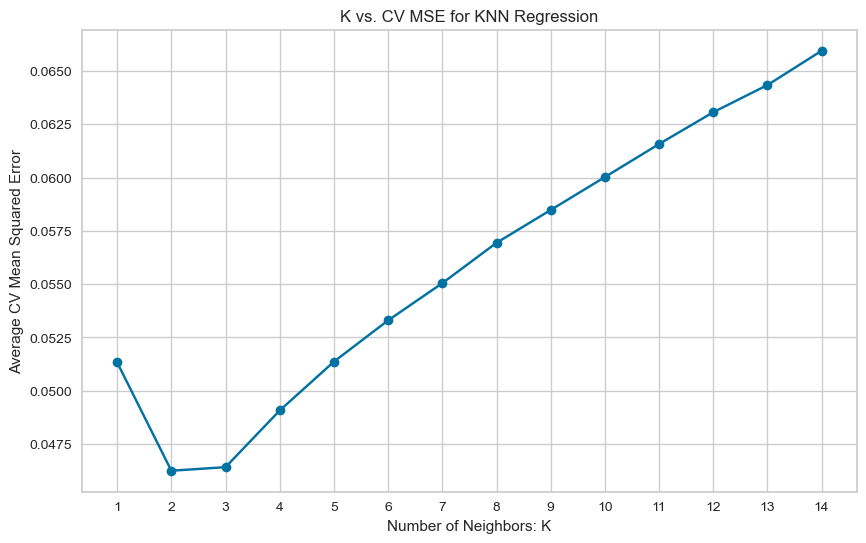

In [35]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import cross_val_score
import numpy as np

# Initialize KNN models with different values of K
k_values = range(1, 15)  
cv_errors = []

for k in k_values:
    # Initialize KNN regressor with current value of K
    knn_model = KNeighborsRegressor(n_neighbors=k)

    # Perform 5-fold cross-validation
    # Use negative mean squared error as the scoring parameter so that a higher score means a better model
    cv_scores = cross_val_score(knn_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

    # Calculate mean of cross-validation scores, and convert from negative MSE to positive MSE
    mean_cv_error = -np.mean(cv_scores)
    cv_errors.append(mean_cv_error)

    print(f"Average CV MSE for K={k}: {mean_cv_error:.4f}")

# Optionally, plot the results to visually compare the CV errors for different values of K
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(k_values, cv_errors, marker='o')
plt.xlabel('Number of Neighbors: K')
plt.ylabel('Average CV Mean Squared Error')
plt.title('K vs. CV MSE for KNN Regression')
plt.xticks(k_values)
plt.grid(True)
plt.show()

# 3. XGBoost Regression

In [36]:
#Define a function for evaluation metrics: MSE, Cross-validation MSE, R2 and adjusted R2

def evaluate_model(model, X_train, y_train, X_test, y_test):
  
    # Fit the model
    model.fit(X_train, y_train)

    # Predict on testing set
    y_pred = model.predict(X_test)

    # Calculate MSE
    mse = mean_squared_error(y_test, y_pred)

    # Calculate Cross-validation MSE
    cv_mse = -np.mean(cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=5))

    # Calculate R-squared
    r2 = r2_score(y_test, y_pred)

    # Calculate Adjusted R-squared
    n = X_test.shape[0]  # Number of observations
    p = X_test.shape[1]  # Number of features
    adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

    return {
        'MSE': mse,
        'CV_MSE': cv_mse,
        'R2': r2,
        'Adjusted_R2': adjusted_r2
    }


In [37]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

#Hyperparameter tuning using CV
# Define a comprehensive parameter grid
param_grid_xgb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7, 9]
}

# Initialize the XGBoost regressor
xgb_model = xgb.XGBRegressor(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid_xgb, cv=5,
                           scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Retrieve the best parameters and the best model
best_params = grid_search.best_params_
xgb_best_model = grid_search.best_estimator_

print(f"Best parameters found: {best_params}")

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters found: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}


In [38]:
# Train the model on the training set
xgb_best_model.fit(X_train, y_train)

# Evaluating the model
xgb_results = evaluate_model(xgb_best_model, X_train, y_train, X_test, y_test)
xgb_results

{'MSE': 0.0031068385982328203,
 'CV_MSE': 0.003775058340367421,
 'R2': 0.9935281368374088,
 'Adjusted_R2': 0.9935032587253066}

# 4. Random Forest Regression

In [39]:
from sklearn.ensemble import RandomForestRegressor

#Hyperparameter tuning using CV

# Define a more comprehensive parameter grid
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30],
    'bootstrap': [True, False]
}

# Initialize the model
rf_model = RandomForestRegressor(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, cv=5,
                           scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Retrieve the best parameters
best_params_rf = grid_search.best_params_
print("Best parameters found: ", best_params_rf)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters found:  {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 200}


In [40]:
rf_model = RandomForestRegressor(**best_params_rf, random_state=42)

# Fit the model to the training data
rf_model.fit(X_train, y_train)

rf_results = evaluate_model(rf_model, X_train, y_train, X_test, y_test)
rf_results

{'MSE': 0.005062320886438101,
 'CV_MSE': 0.0062005976563810255,
 'R2': 0.9894546668498357,
 'Adjusted_R2': 0.9894141301490937}

# 5. Support Vector Regression

In [41]:
from sklearn.svm import SVR

# Create an SVR model
svr_model = SVR()

# Train the SVR model
svr_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = svr_model.predict(X_test)

# Calculate the Mean Squared Error & R2
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

Mean Squared Error: 0.007193447910822539
R-squared: 0.9850153108782184


# V. Model Training (PyCaret)

In [42]:
from pycaret.regression import *

# Concat X and y back into 1 DataFrame
df_train_transformed = pd.concat([X_train, y_train], axis=1)

s = setup(df_train_transformed, target = 'Log_Price',session_id=256, fold_strategy='kfold', fold=10)

best_model_1 = compare_models(sort='MSE',  # Sort performance by MSE
                              include=['svm', 'knn', 'rf','xgboost',],
                              verbose=True)

,Description,Value
0,Session id,256
1,Target,Log_Price
2,Target type,Regression
3,Original data shape,"(7313, 8)"
4,Transformed data shape,"(7313, 8)"
5,Transformed train set shape,"(5119, 8)"
6,Transformed test set shape,"(2194, 8)"
7,Numeric features,7
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
xgboost,Extreme Gradient Boosting,0.0488,0.0042,0.0648,0.9915,0.0064,0.0054,0.0130
rf,Random Forest Regressor,0.0533,0.0050,0.0708,0.9899,0.0070,0.0058,0.0820
svm,Support Vector Regression,0.0696,0.0082,0.0907,0.9834,0.0091,0.0077,0.2630
knn,K Neighbors Regressor,0.1690,0.0592,0.2431,0.8805,0.0241,0.0186,0.1620


In [43]:
# Since best model is XGBoost, run model on test set
df_test_transformed = pd.concat([X_test, y_test], axis=1)

y_pred = predict_model(best_model_1, data=df_test_transformed)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extreme Gradient Boosting,0.0461,0.0036,0.0604,0.9924,0.0060,0.0051


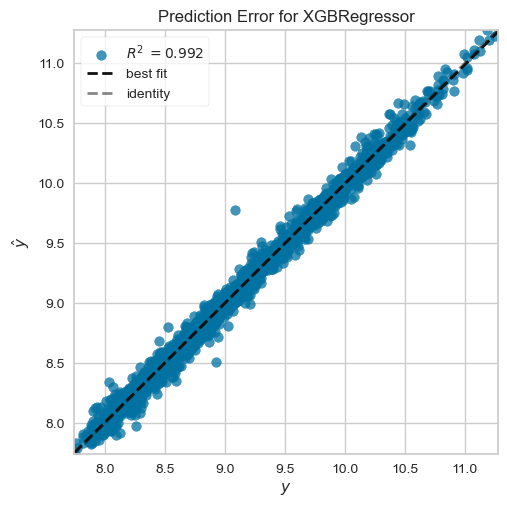

In [48]:
#error plot
plot_model(best_model_1, plot='error')



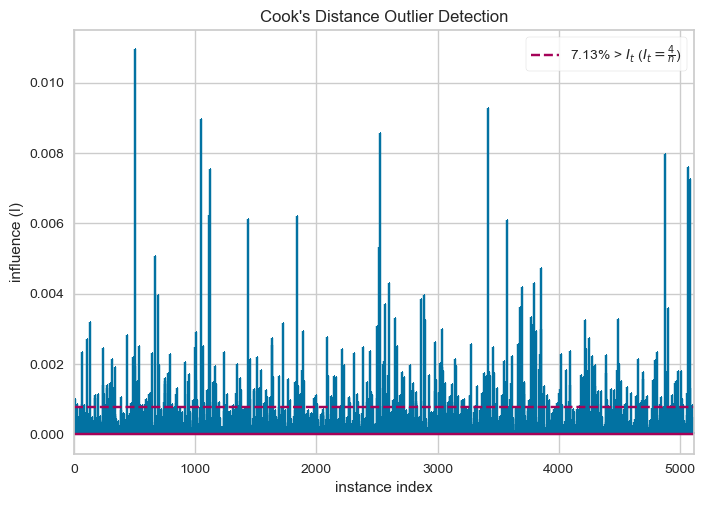

In [49]:
#cooks distance plot
plot_model(best_model_1, plot='cooks')

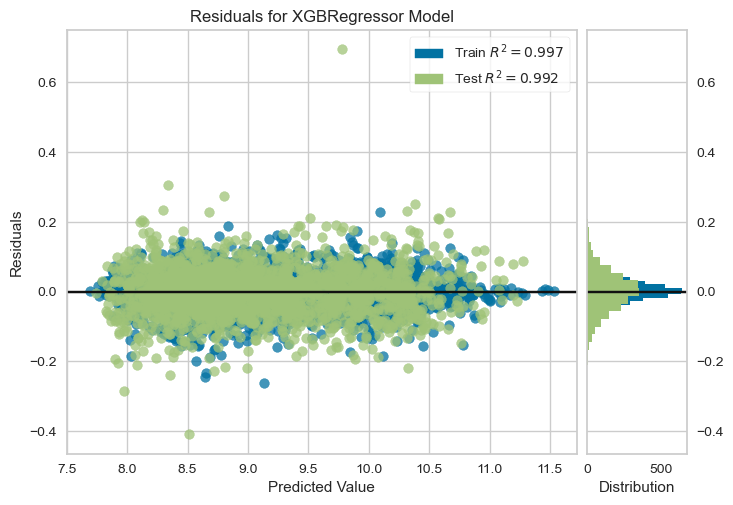

In [50]:
#risidual plot
plot_model(best_model_1, plot='residuals')